# A Network Tour of the Tunisian and Egyptian Springs

**Khalil Mrini, Khalid Omari, Ana Stanojevic**

## Table of Contents

#### [Introduction](#0)

#### [1. The Dataset](#1)
- [1.1. Imports](#11)
- [1.2. Loading Dataframes](#12)
- [1.3. Filtering Data](#13)

#### [2. Graph-Based Post Clustering Pipeline](#2)
- [2.1. Conceptual Representation of Posts using Word Embeddings](#21)
- [2.2. Feature Normalization](#22)
- [2.3. Distances in the Similarity Graph](#23)
- [2.4. Weighted Adjacency Matrix](#24)
- [2.5. Cluster Posts using Laplacian Eigendecomposition](#25)
- [2.6. Cluster Keywords](#26)
- [2.7. Post Clustering Pipeline](#27)

#### [3. Post Clustering Results by Country and Post Type](#3)
- [3.1. Egypt, Social Media](#31)
- [3.2. Egypt, Mainstream News](#32)
- [3.3. Egypt, Web Blogs](#33)
- [3.4. Tunisia, Social Media](#34)
- [3.5. Tunisia, Mainstream News](#35)
- [3.6. Tunisia, Web Blogs](#36)

#### [4. An Experiment with Convolutional Neural Networks on Graphs with Fast Localized Spectral Filtering](#4)
- [4.1. Storing data in convenient format for *cnn_graph* library](#41)
- [4.2. Train data](#42)
- [4.3. Test data](#43)
- [4.4. Words graph](#44)
- [4.5. Validation data](#45)
- [4.6. Classification](#46)

#### [5. Constructing social graph with named-entities](#5)
- [5.1. English Dictionary](#51)
- [5.2. Filter Tokens](#52)
- [5.3. Social Graph Construction](#53)
- [5.4. Degree Distribution](#54)
- [5.5. Connected Components](#55)
- [5.6. Graph Centrality](#56)
- [5.7. Pruning the Graph](#57)
- [5.8. Ego Graph](#58)

#### [Conclusion](#6)

## Introduction <a class="anchor" id="0"></a>

In the 2011 Arab Spring, the two most significant revolutions happened in Tunisia and Egypt. Seven years
later, we aim to revisit the most recurrent demands expressed by the people on social media, as well as how
the news media covered the events. We want to show the topics most discussed on the web, and the links
between topics, people, events and places. Through this project, we aim to give a new graph-oriented insight
into the revolutions.

## 1. The Dataset <a class="anchor" id="1"></a>

The Dataset we chose is the [Data Challenge of the 2011 ICWSM](https://goo.gl/qUXTDn) (Fifth International AAAI Conference on Weblogs and Social Media), provided by Spinn3r, a company that provides a web scraping API. The data here is posts found online between January 13, 2011 to February 14, 2011, roughly encompassing the end of the Tunisian Revolution and the beginning of the Egyptian one.

### 1.1. Imports <a class="anchor" id="11"></a>

In [2]:
import pickle
import pandas as pd
import numpy as np
import numexpr as ne
import matplotlib.pyplot as plt
import tensorflow as tf
import time

from pygsp import graphs, filters, plotting
from lib import models, graph, coarsening, utils, clustering
import importlib
importlib.reload(clustering)

%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.insert(0, '..')

import json
import scipy
from scipy import spatial, sparse
import scipy.sparse.linalg

from sklearn.cluster import KMeans
import operator
import io
get_ipython().magic('matplotlib inline')

### 1.2. Loading Dataframes <a class="anchor" id="12">

There are 3 sources of media (or **post types**): Mainstream News, Social Media and Web Blogs.

In [3]:
PATH_PREFIX = './data/'
FILE_NAMES = 'MAINSTREAM_NEWS SOCIAL_MEDIA WEBLOG'.split()

df = pd.concat([pd.read_pickle('{}{}_en.pkl'.format(PATH_PREFIX, file_name)) 
                for file_name in FILE_NAMES]).reset_index(drop=True).drop(
                labels='Lang_Code', axis=1)
df['Joined_Tokens'] = df.Tokens.apply(lambda tokens: ' '.join(tokens))
df = df.drop_duplicates(subset='Joined_Tokens').drop(labels='Joined_Tokens', axis=1)
df.head()

,Author_Name,Datetime,Egypt,Identifier,Post_Link,Tunisia,Type,Day,Tokens
0,Clark Forsythe,2011-01-25T01:59:00Z,4,1295936336220463105,http://www.weeklystandard.com/blogs/supreme-co...,4,MAINSTREAM_NEWS,2011-01-25,"[back, alley, runs, philadelphia, large, part,..."
1,Michael Weiss,2011-01-24T22:00:00Z,4,1295936336220463117,http://www.weeklystandard.com/blogs/palestine-...,4,MAINSTREAM_NEWS,2011-01-24,"[first, thing, dump, documents, support, unity..."
2,Daniel Halper,2011-01-24T20:00:00Z,3,1295936336220463125,http://www.weeklystandard.com/blogs/will-obama...,6,MAINSTREAM_NEWS,2011-01-24,"[democracy, times, revolt, tunisia, nation, po..."
11,,2011-01-25T05:00:39Z,6,1295935188011796489,http://www.nationalreview.com/articles/257830/...,8,MAINSTREAM_NEWS,2011-01-25,"[belarus, part, series, belarus, country, hell..."
12,,2011-01-25T05:00:37Z,4,1295935188011796491,http://www.nationalreview.com/articles/257831/...,4,MAINSTREAM_NEWS,2011-01-25,"[investment, euphemism, help, something, diffe..."


Each row in the Dataframe represent a post, with a unique `Identifier`. The column `Type` represents the source of the media. The words in the posts have been tokenized, deprived of stop words, and bigrams were formed. They are stored as a list of strings in `Tokens`.

After having taken keywords automatically from the Wikipedia articles for the Egyptian and Tunisian revolutions, we filtered the original dataset to only keep posts that contain at least 4 keywords. The number of keywords for each country is noted in the columns `Tunisia` and `Egypt`.

The number of posts is the following:

In [4]:
len(df)

188755

The distribution of the post types is as follows:

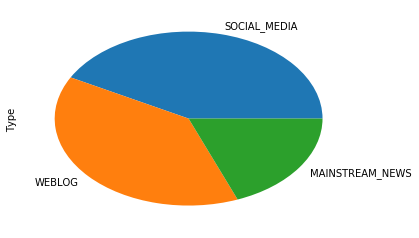

In [5]:
df.Type.value_counts().plot.pie();

### 1.3. Filtering Data <a class="anchor" id="13">

Given that the data above is too large, we filter it to get quality data that is appropriate for our topic. For each post type, we keep the posts that have as keyword score (sum of the values in `Tunisia` and `Egypt`) one that is higher than the mean score, and then the posts that have more tokens than the median:

In [6]:
for post_type in FILE_NAMES:
    mean_score = df[df.Type == post_type][['Tunisia', 'Egypt']].sum(axis=1).mean()
    df[df.Type == post_type] = df[(df.Type == post_type) 
                                  & (df.Tunisia + df.Egypt > mean_score)]
    median_length = df[df.Type == post_type].dropna().Tokens.apply(len).median()
    df[df.Type == post_type] = df[(df.Type == post_type)
                                  & (df.Tokens.apply(lambda tokens: type(tokens) == list and len(tokens) > median_length))]
df = df.dropna().reset_index(drop=True)

After filtering, the number of posts is:

In [7]:
len(df)

28987

The distribution remains approximately the same:

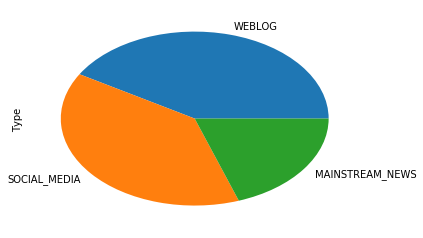

In [8]:
df.Type.value_counts().plot.pie();

## 2. Graph-Based Post Clustering Pipeline <a class="anchor" id="2"></a>

In this section, we create a graph-based post clustering pipeline. This pipeline is akin to a **topic detection** method that assumes posts only tackle one topic. We first describe the different components that are used in order in the pipeline, before compiling it in subsection [2.7](#27). In the next section, we show the results of this timeline.

### 2.1. Conceptual Representation of Posts using Word Embeddings <a class="anchor" id="21"></a>

We consider a post $p$ as a sequence of $n$ tokens: $p = \left \langle t_1, t_2, ..., t_n \right \rangle$. A token $t$ is a single string, that may contain up to 2 words joined by an underscore, such as `ben_ali` (last name of the ousted Tunisian President). Given an embedding model $m$, we consider that the embedding, or vectorial representation, of a token $t_i$ is $\vec{t_i} = m[t_i]$. We consider the embedding of a post $p$ as the average of the vectorial representations of its words, such that: $\vec{p_i} = \frac{1}{n}\sum_{i = 1}^{n}\vec{t_i}$.

We use the following method to map a post to a vector:

In [10]:
def get_post_embedding(tokens, model, dimension):
    """
    Gets post embedding by average the vector representations of its tokens.
    :param tokens: list of strings, tokens of the post
    :param model: embedding model
    :param dimension: int, dimension of embedding
    :return: list of float, of size dimension
    """
    count = 0
    vector = np.zeros(dimension)
    for token in tokens:
        try:
            vector = vector + model[token]
            count += 1
        except:
            pass
    if count > 0:
        vector = vector / count
    return vector

We will use Facebook's **FastText** to train an embedding model. We use it instead of Google's pre-trained word2vec because FastText has the ability to embed out-of-vocabulary words and its ability to model words by taking in consideration character n-grams. We use the gensim implementation:

In [11]:
from gensim.models import FastText

### 2.2. Feature Normalization <a class="anchor" id="22"></a>

We can consider that the post vectors are features in topic detection, and as such they need to be normalized to be more efficient:

In [12]:
def normalize_features(features):
    """
    Normalizes features of a Pandas Dataframe.
    :param features: DataFrame
    :return: DataFrame
    """
    features -= features.mean(axis=0)
    features /= features.std(axis=0)
    return features

### 2.3. Distances in the Similarity Graph <a class="anchor" id="23"></a>

One of the properties of word embeddings is that they are conceptually similar if their **cosine similarity** is high. We will therefore use **cosine distance** to compute the distances in our graph:

In [13]:
def compute_distances(features):
    """
    Computes distances from features.
    :param features: DataFrame
    :return: DataFrame
    """
    distances = spatial.distance.squareform(spatial.distance.pdist(features, 'cosine'))
    return distances

### 2.4. Weighted Adjacency Matrix <a class="anchor" id="24"></a>

Now that we can compute distances, we use the Gaussian kernel to compute edge weights. It is defined as: $$\mathbf{W}(u,v) = \exp \left(-\left( \frac{d(u, v)}{\sigma} \right)^2\right),$$
where $\sigma$ is a parameter which controls the width of the kernel, that we set at the mean of distances.

To avoid creating a fully connected graph, we sparsify it as well. The function used is as follows:

In [14]:
def compute_weights(distances, neighbours=100):
    """
    Computes the adjacency matrix.
    :param distances: distance matrix
    :param neighbours: int, to sparsify matrix
    :return: weights, matrix of float
    """
    kernel_width = distances.mean()
    weights = ne.evaluate('exp(-1 * (distances * distances) / (kernel_width * kernel_width))')
    np.fill_diagonal(weights, 0)
    indices_to_evict = np.argsort(weights)[:,:-neighbours]
    post_count = len(weights)
    for index in range(post_count):
        weights[index][indices_to_evict[index]] = 0.0
    for i in range(post_count):
        for j in range(i + 1, post_count):
            maximum = max(weights[i][j], weights[j][i])
            weights[i][j] = maximum
            weights[j][i] = maximum
    return weights

### 2.5. Cluster Posts using Laplacian Eigendecomposition <a class="anchor" id="25"></a>

The following function clusters topics using Laplacian Graph Eigendecomposition:

In [15]:
def cluster_posts(weights, n_clusters=5):
    """
    Clusters posts using Laplacian Graph Eigendecompositon.
    :param weights: Adjacency Matrix weights
    :param n_clusters: number of post clusters
    :return: list of indexes of clusters for each post
    """
    laplacian = sparse.csgraph.laplacian(weights, normed=True, use_out_degree=True)
    laplacian = sparse.csr_matrix(laplacian)
    eigenvalues, eigenvectors = sparse.linalg.eigsh(laplacian, k=n_clusters, which = 'SA')
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(eigenvectors)
    cluster_labels = kmeans.labels_
    return [cluster_labels, eigenvectors[:,1:3], eigenvalues]

### 2.6. Cluster Keywords <a class="anchor" id="26"></a>

We use the following function to get keywords specific to each cluster discovered above:

In [125]:
def get_post_cluster_keywords(df, cluster_labels, n_clusters=5, max_words=40):
    """
    Looks for cluster keywords with TF-IDF.
    :param df: DataFrame
    :param cluster_labels: cluster labels for each post
    :param n_clusters: number of clusters
    :param max_words: maximum number of popular keywords to get per cluster
    :return: specific cluster keywords
    """
    term_frequency = [dict() for cluster_index in range(n_clusters)]
    document_frequency = [dict() for cluster_index in range(n_clusters)]
    document_count = [len([label for label in cluster_labels if label == cluster_index]) 
                      for cluster_index in range(n_clusters)]
    for index, label in enumerate(cluster_labels):
        tokens = df.iloc[index].Tokens
        for token in set(tokens):
            try:
                document_frequency[label][token] += 1
            except:
                document_frequency[label][token] = 1
        for token in tokens:
            try: 
                term_frequency[label][token] += 1
            except:
                term_frequency[label][token] = 1
    max_term_frequency = [np.max(list(term_frequency[cluster_index].values())) for cluster_index in range(n_clusters)]
    total = {}
    sorted_tokens = {}
    keywords = []
    for cluster_index in range(n_clusters):
        tf_idf = dict((token, (term_frequency[cluster_index][token]/max_term_frequency[cluster_index])
                       *np.log(document_count[cluster_index]/document_frequency[cluster_index][token]))
                      for token in term_frequency[cluster_index])
        sorted_tokens[cluster_index] = sorted(tf_idf.items(), key=operator.itemgetter(1), reverse=True)[:max_words]
        for token, score in sorted_tokens[cluster_index]:
            try:
                total[token] += 1
            except:
                total[token] = 1
    keywords = [[(token, total[token]) for token, score in sorted_tokens[cluster_index]]
                for cluster_index in range(n_clusters)]
    return keywords

### 2.7. Post Clustering Pipeline <a class="anchor" id="27"></a>

The following method uses all of the above to cluster posts.

In [126]:
def post_clustering_pipeline(df, dimension=300, show=True, neighbours=100, n_clusters=3, max_words=40):
    """
    Clusters posts of the DataFrame in arguments.
    :param df: DataFrame
    :param dimension: size of embeddings
    :param show: boolean, to visualize results
    :param neighbours: minimum number of neighbours per post
    :param n_clusters: number of post clusters
    :param max_words: maximum number of keywords per cluster
    """
    print('The number of posts is {}.'.format(len(df)))
    print('2.1. Training FastText model...')
    token_list = list(df.Tokens)
    model = FastText(token_list, size=dimension, workers=50, batch_words=5000, min_count=20)
    print('2.1. Getting Post Embeddings...')
    features = pd.DataFrame([get_post_embedding(tokens, model, dimension) for tokens in token_list])
    print('2.2. Feature Normalisation...')
    features = normalize_features(features)
    print('2.3. Computing Distances...')
    distances = compute_distances(features)
    print('2.4. Computing Weights...')
    weights = compute_weights(distances, neighbours=neighbours)
    print('2.5. Clustering Posts...')
    [cluster_labels, eigenvectors, eigenvalues] = cluster_posts(weights, n_clusters=n_clusters)
    if show:
        fix, axes = plt.subplots(2, 2, figsize=(17, 8))
        sorted_weights = np.argsort(cluster_labels)
        axes[0,0].spy(weights[sorted_weights,:][:,sorted_weights])
        axes[0,0].set_title('The Adjacency Matrix')
        axes[1,0].hist(weights[weights > 0].reshape(-1), bins=50);
        axes[1,0].set_title('Distribution of the Weights')
        axes[0,1].plot(eigenvalues, '.-', markersize=15);
        axes[0,1].set_title('Eigenvalues')
        axes[1,1].scatter(eigenvectors[:,0], eigenvectors[:,1], c=cluster_labels, cmap='RdYlGn')
        axes[1,1].set_title('Visualisation of the Clusters')
    print('2.6. Getting Cluster Keywords...')
    cluster_keywords = get_post_cluster_keywords(df, cluster_labels, n_clusters=n_clusters, max_words=max_words)
    print('Done!')
    return cluster_keywords

## 3. Post Clustering Results by Country and Post Type <a class="anchor" id="3"></a>

In this section, we show the results of our post clustering pipeline. A post is affiliated to a given country, if its keyword score for that country is higher or equal than the one for the other country.

In [127]:
# Countries
EG = 'Egypt'
TN = 'Tunisia'

# Post Types
SM = 'SOCIAL_MEDIA'
WB = 'WEBLOG'
MN = 'MAINSTREAM_NEWS'

# Keywords dict
cluster_keywords = {}

def get_cluster_keywords(df, country, post_type):
    """
    Returns cluster keywords results of post clustering for given country and post type.
    :param df: entire DataFrame
    :param country: string
    :param post_type: string
    :return: list of list of strings
    """
    other_country = EG if country == TN else TN
    return post_clustering_pipeline(df[(df[country] >= df[other_country]) & (df.Type == post_type)])

We create 3 clusters and analyse them. The indexes of the clusters (0, 1, 2) correspond to the colors of the `RdYlGn` colormap (Red, Yellow, Green).

### 3.1. Egypt, Social Media <a class="anchor" id="31"></a>

The number of posts is 9376.
2.1. Training FastText model...
2.1. Getting Post Embeddings...
2.2. Feature Normalisation...
2.3. Computing Distances...
2.4. Computing Weights...
2.5. Clustering Posts...
2.6. Getting Cluster Keywords...
Done!


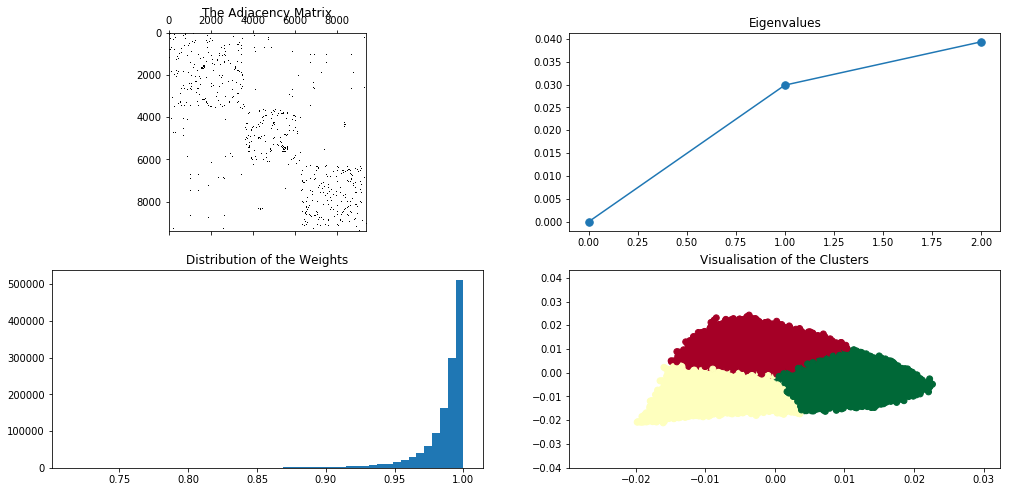

In [128]:
cluster_keywords[(EG, SM)] = get_cluster_keywords(df, EG, SM)

Here, we provide some analysis of the clusters. We first view their keywords:

In [135]:
from termcolor import colored

def view_clusters(country, post_type):
    """
    Print the keywords of each cluster and in how many clusters they appear.
    :param country: string
    :param post_type: string
    """
    color = 'Red Yellow Green'.split()
    for cluster_index in range(len(cluster_keywords[(country, post_type)])):
        print(colored(color[cluster_index] + ' Cluster:', color[cluster_index].lower()))
        print(' - '.join([str(element) for element in cluster_keywords[(country, post_type)][cluster_index]]))
        print()

view_clusters(EG, SM)

Red Cluster:
('mubarak', 3) - ('people', 3) - ('government', 3) - ('egyptian', 3) - ('egypt', 3) - ('revolution', 3) - ('power', 3) - ('protests', 3) - ('protesters', 3) - ('president', 3) - ('military', 3) - ('tunisia', 3) - ('egyptians', 3) - ('democracy', 2) - ('regime', 2) - ('iran', 1) - ('new', 3) - ('country', 3) - ('world', 2) - ('many', 3) - ('freedom', 1) - ('years', 2) - ('time', 2) - ('peaceful', 2) - ('protest', 2) - ('israel', 1) - ('united_states', 1) - ('police', 3) - ('obama', 1) - ('american', 2) - ('support', 1) - ('free', 1) - ('dictator', 1) - ('change', 1) - ('leaders', 1) - ('democratic', 1) - ('violence', 2) - ('good', 1) - ('uprising', 1) - ('way', 2)

Yellow Cluster:
('people', 3) - ('egypt', 3) - ('egyptian', 3) - ('government', 3) - ('new', 3) - ('world', 2) - ('many', 3) - ('protests', 3) - ('time', 2) - ('band', 1) - ('protesters', 3) - ('mubarak', 3) - ('police', 3) - ('revolution', 3) - ('music', 1) - ('country', 3) - ('album', 1) - ('news', 2) - ('inter

We see that all three clusters talk about the Egyptian president (`mubarak`).
1. The Red Cluster focuses on **international reactions**, with mentions of countries like Israel, United States, Iran, as well as mentions of support, change, leaders, signalling US support for the revolution at the time. Obama is also cited. 
2. The Yellow Cluster is about **the media**, and how people connected, with words like internet, media, group, political.
3. The Green Cluster is about **Protests** with words like Friday (the day the protests were at their highest), thousands, demonstrators, protestors, streets, demonstrations.

We notice that the clusters don't seem to be too disparate in the visualisation, but the adjacency matrix shows they are in fact well separated. The distribution of the weights is skewed towards 1, probably because social media posts are short and are likely to share similar vocabulary.

### 3.2. Egypt, Mainstream News <a class="anchor" id="32"></a>

The number of posts is 4551.
2.1. Training FastText model...
2.1. Getting Post Embeddings...
2.2. Feature Normalisation...
2.3. Computing Distances...
2.4. Computing Weights...
2.5. Clustering Posts...
2.6. Getting Cluster Keywords...
Done!


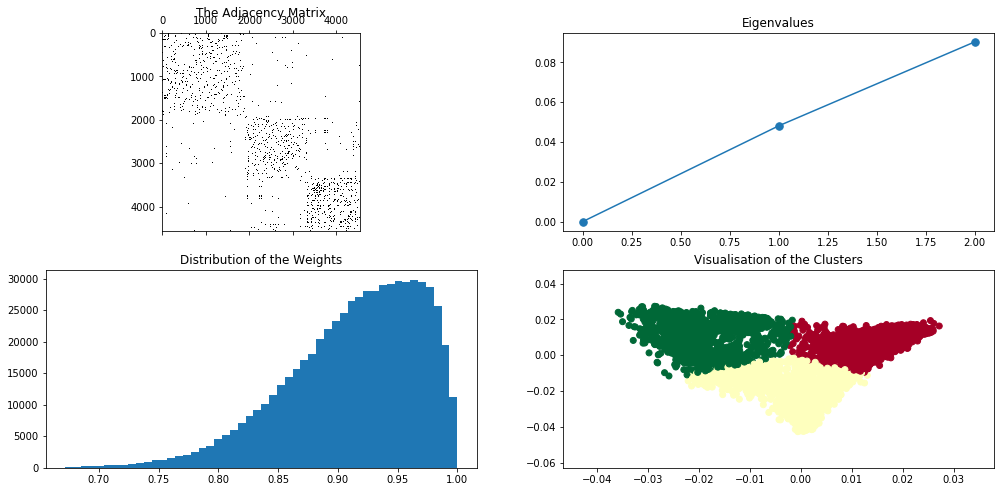

In [136]:
cluster_keywords[(EG, MN)] = get_cluster_keywords(df, EG, MN)

Here, the distribution of weights is not as skewed as the one for Social Media, as mainstream news articles are longer and unlikely to match perfectly.

In [141]:
view_clusters(EG, MN)

Red Cluster:
('egypt', 1) - ('students', 1) - ('china', 1) - ('president', 3) - ('america', 2) - ('american', 2) - ('internet', 1) - ('information', 1) - ('jobs', 1) - ('new', 2) - ('free', 1) - ('percent', 1) - ('police', 2) - ('world', 2) - ('school', 1) - ('state', 3) - ('military', 3) - ('business', 1) - ('law', 1) - ('reagan', 1) - ('security', 3) - ('beck', 1) - ('economy', 1) - ('work', 1) - ('party', 2) - ('egyptian', 2) - ('federal', 1) - ('mubarak', 2) - ('people', 1) - ('haiti', 1) - ('war', 1) - ('news', 2) - ('political', 3) - ('americans', 1) - ('children', 1) - ('money', 1) - ('system', 1) - ('year', 1) - ('nation', 1) - ('women', 1)

Yellow Cluster:
('israel', 1) - ('brotherhood', 2) - ('iran', 1) - ('military', 3) - ('mubarak', 2) - ('palestinian', 1) - ('israeli', 1) - ('hezbollah', 1) - ('tunisia', 2) - ('revolution', 2) - ('islamic', 1) - ('lebanon', 1) - ('arab', 1) - ('american', 2) - ('regime', 2) - ('muslim', 1) - ('peace', 1) - ('democracy', 2) - ('america', 2)

The adjacency matrix shows the red and green clusters are not related at all, but the yellow one shares some connections with the other two.
1. Red Cluster mentions the student-led 2011 Chinese pro-democracy protests, inspired by the Arab Spring.
2. Yellow Cluster is about international reactions, especially from the region (Israel, Iran, Palestine, Lebanon) and the US (Obama).
3. Green Cluster is about the Revolution, with mentions of Suleiman who announced the resignation of Egypt's President.

### 3.3. Egypt, Web Blogs <a class="anchor" id="33"></a>

The number of posts is 9853.
2.1. Training FastText model...
2.1. Getting Post Embeddings...
2.2. Feature Normalisation...
2.3. Computing Distances...
2.4. Computing Weights...
2.5. Clustering Posts...
2.6. Getting Cluster Keywords...
Done!


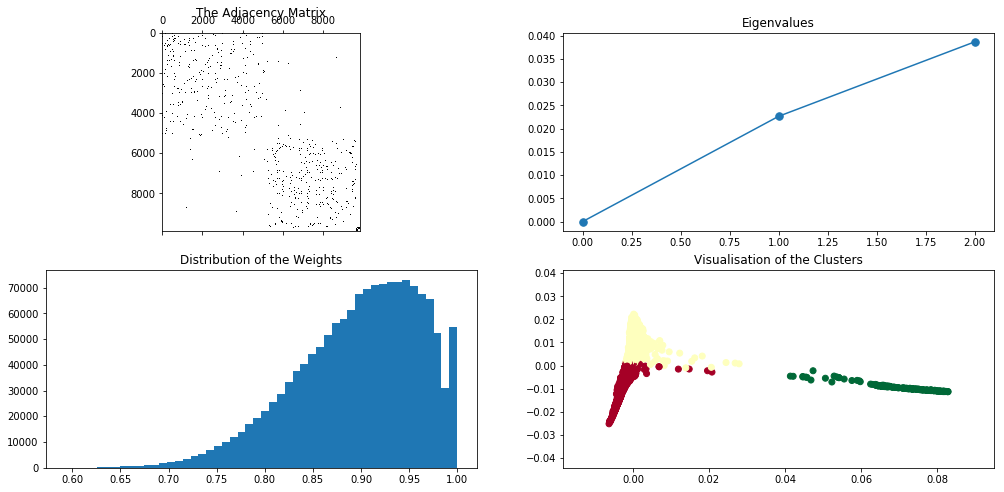

In [137]:
cluster_keywords[(EG, WB)] = get_cluster_keywords(df, EG, WB)

Here we see in both the adjacency matrix and the visualisation that the red and yellow clusters in fact form only one.

In [142]:
view_clusters(EG, WB)

Red Cluster:
('israel', 3) - ('protesters', 1) - ('iran', 1) - ('israeli', 1) - ('suleiman', 1) - ('brotherhood', 1) - ('tunisia', 1) - ('army', 1) - ('palestinian', 1) - ('police', 2) - ('military', 2) - ('arab', 1) - ('american', 2) - ('revolution', 1) - ('square', 1) - ('washington', 1) - ('gaza', 1) - ('hamas', 1) - ('america', 2) - ('january', 2) - ('cairo', 1) - ('democracy', 1) - ('protests', 1) - ('obama', 2) - ('elbaradei', 1) - ('islamic', 1) - ('regime', 1) - ('united_states', 2) - ('world', 1) - ('region', 1) - ('friday', 1) - ('muslim', 2) - ('president', 1) - ('palestinians', 1) - ('demonstrators', 1) - ('group', 1) - ('peace', 1) - ('democratic', 1) - ('workers', 1) - ('freedom', 1)

Yellow Cluster:
('india', 1) - ('guest', 1) - ('iraq', 1) - ('china', 1) - ('pakistan', 1) - ('egypt', 2) - ('israel', 3) - ('god', 1) - ('women', 1) - ('war', 1) - ('indian', 1) - ('jewish', 1) - ('police', 2) - ('church', 1) - ('law', 1) - ('mubarak', 2) - ('dan', 1) - ('american', 2) - ('

Indeed, the predictions of the adjacency matrix shows common vocabulary patterns in the Red and Yellow cluster (mentions of countries and religion) although the top words are not shared. The Green Cluster is separate and varied in topics, ranging from reform and protests in Egypt to business and investment.

### 3.4. Tunisia, Social Media <a class="anchor" id="34"></a>

The number of posts is 2619.
2.1. Training FastText model...
2.1. Getting Post Embeddings...
2.2. Feature Normalisation...
2.3. Computing Distances...
2.4. Computing Weights...
2.5. Clustering Posts...
2.6. Getting Cluster Keywords...
Done!


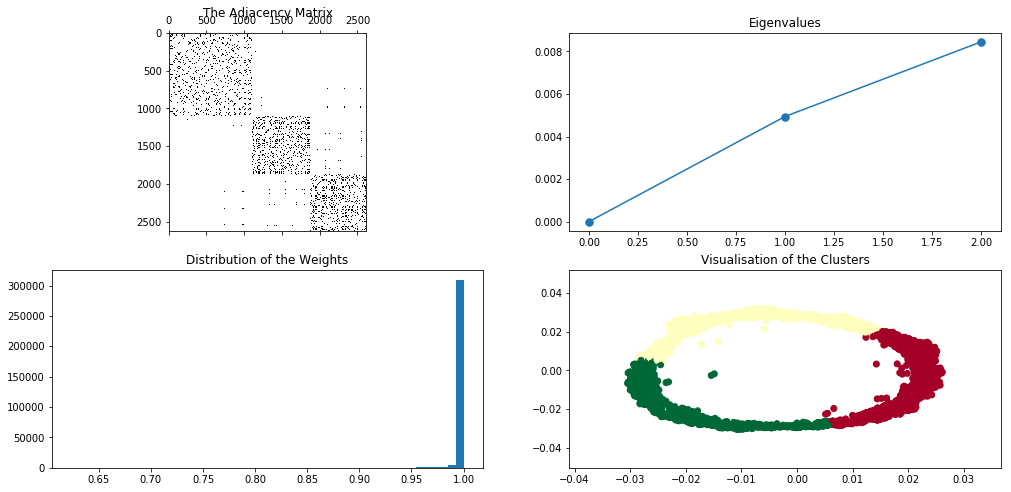

In [138]:
cluster_keywords[(TN, SM)] = get_cluster_keywords(df, TN, SM)

Although it is not visible in the visualisation, we have three very well connected clusters as can be seen in the adjacency matrix. The weights are very skewed towards 1, indicating close similarity in the vocabulary.

In [143]:
view_clusters(TN, SM)

Red Cluster:
('people', 3) - ('government', 3) - ('tunisian', 3) - ('egypt', 3) - ('protests', 2) - ('revolution', 2) - ('president', 3) - ('protesters', 2) - ('egyptian', 2) - ('police', 3) - ('tunisia', 3) - ('power', 2) - ('country', 2) - ('yemen', 1) - ('protest', 1) - ('mubarak', 2) - ('new', 3) - ('countries', 2) - ('iran', 1) - ('world', 3) - ('democracy', 2) - ('uprising', 1) - ('arab', 2) - ('many', 3) - ('governments', 2) - ('freedom', 2) - ('tunis', 1) - ('streets', 2) - ('years', 3) - ('algeria', 1) - ('cairo', 1) - ('dictator', 1) - ('unrest', 1) - ('regime', 2) - ('day', 3) - ('egyptians', 1) - ('leaders', 1) - ('political', 2) - ('lebanon', 1) - ('news', 2)

Yellow Cluster:
('people', 3) - ('government', 3) - ('tunisia', 3) - ('new', 3) - ('tunisian', 3) - ('many', 3) - ('world', 3) - ('police', 3) - ('egypt', 3) - ('revolution', 2) - ('country', 2) - ('president', 3) - ('protests', 2) - ('party', 2) - ('international', 2) - ('power', 2) - ('time', 2) - ('protesters', 2)

1. Red Cluster: Domino Effect, or the influence of Tunisia over other countries (Yemen, Egypt).
2. Yellow Cluster: International Reactions and Media, with mentions of the US, Facebook, international and Arab.
3. Green Cluster: Noise, as it mentions other events around the world and some discussion about music.

### 3.5. Tunisia, Mainstream News <a class="anchor" id="35"></a>

The number of posts is 1809.
2.1. Training FastText model...
2.1. Getting Post Embeddings...
2.2. Feature Normalisation...
2.3. Computing Distances...
2.4. Computing Weights...
2.5. Clustering Posts...
2.6. Getting Cluster Keywords...
Done!


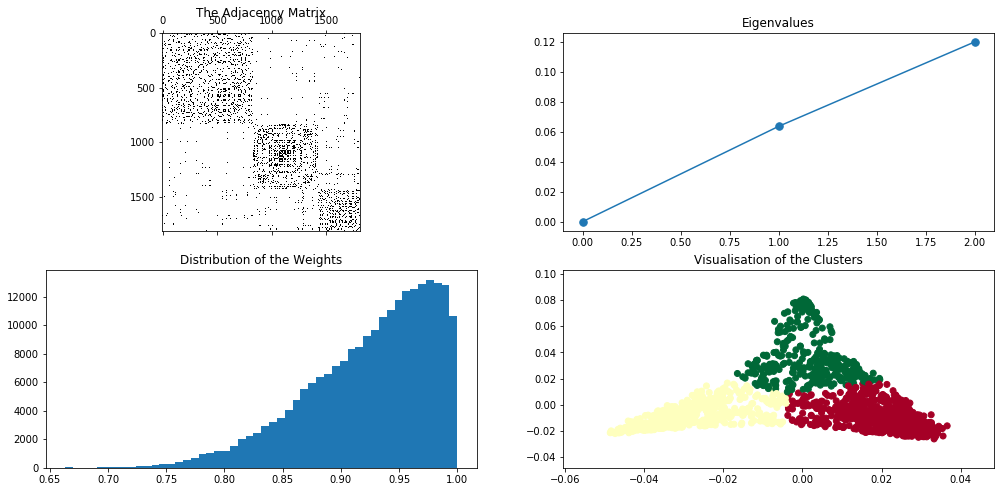

In [139]:
cluster_keywords[(TN, MN)] = get_cluster_keywords(df, TN, MN)

Here we notice that clusters are not as sharply defined, and that weights are distributed, showing diversity in topics.

In [144]:
view_clusters(TN, MN)

Red Cluster:
('students', 1) - ('china', 1) - ('cameron', 1) - ('health', 1) - ('labour', 1) - ('school', 1) - ('reagan', 1) - ('film', 1) - ('tax', 1) - ('information', 1) - ('president', 3) - ('state', 3) - ('percent', 2) - ('american', 1) - ('vote', 1) - ('world', 3) - ('city', 1) - ('vessel', 1) - ('police', 3) - ('news', 1) - ('law', 1) - ('money', 1) - ('chinese', 1) - ('business', 1) - ('canada', 1) - ('system', 1) - ('countries', 2) - ('children', 1) - ('security', 2) - ('party', 2) - ('year', 1) - ('federal', 1) - ('food', 1) - ('oil', 1) - ('economy', 1) - ('energy', 1) - ('banks', 1) - ('global', 1) - ('speech', 1) - ('free', 1)

Yellow Cluster:
('arab', 2) - ('haiti', 1) - ('egypt', 2) - ('revolution', 1) - ('sudan', 2) - ('democracy', 1) - ('duvalier', 1) - ('tunisian', 1) - ('mubarak', 1) - ('tunis', 1) - ('party', 2) - ('world', 3) - ('opposition', 1) - ('protesters', 1) - ('police', 3) - ('internet', 1) - ('regime', 1) - ('new', 1) - ('yemen', 1) - ('january', 1) - ('fr

1. Red Cluster: the largest cluster seams to mention again the 2011 Tunisian-inspired student-led protests in China, as well as as a Chinese loan Cameroon secured in Jan 2011 to build deep sea port at Kribi, terminal of an oil pipeline from Chad.
2. Yellow Cluster: Protests in Tunisia (democracy, protests) and influences on other countries (Egypt, Sudan, Yemen).
3. Green Cluster: Mainly mentions a wide array of regions and countries around the world.

### 3.6. Tunisia, Web Blogs <a class="anchor" id="36"></a>

The number of posts is 3138.
2.1. Training FastText model...
2.1. Getting Post Embeddings...
2.2. Feature Normalisation...
2.3. Computing Distances...
2.4. Computing Weights...
2.5. Clustering Posts...
2.6. Getting Cluster Keywords...
Done!


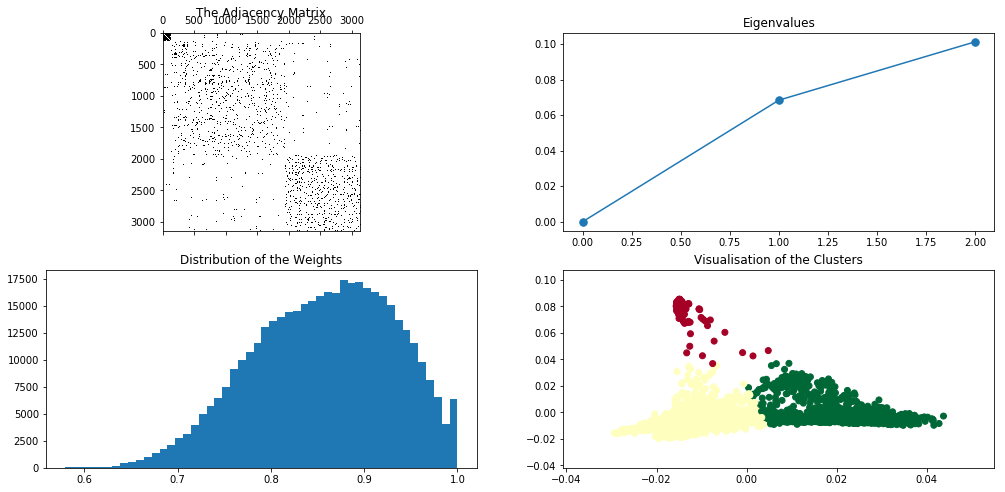

In [140]:
cluster_keywords[(TN, WB)] = get_cluster_keywords(df, TN, WB)

The Red Cluster is very small, but well formed and distinct, as can be seen in the adjacency matrix. The other two larger clusters are not as sharply defined.

In [145]:
view_clusters(TN, WB)

Red Cluster:
('bulgaria', 1) - ('aid', 1) - ('bulgarian', 1) - ('blair', 1) - ('poland', 1) - ('polish', 1) - ('inquiry', 1) - ('women', 2) - ('saddam', 1) - ('russian', 1) - ('jeffrey', 1) - ('kuwait', 1) - ('slovak', 1) - ('evidence', 1) - ('czech', 1) - ('children', 2) - ('nouri', 1) - ('request', 1) - ('europe', 1) - ('unit', 1) - ('straw', 1) - ('regime', 2) - ('croatia', 1) - ('abortion', 1) - ('afghanistan', 1) - ('russia', 2) - ('usg', 1) - ('agreement', 1) - ('veterans', 1) - ('rocket', 1) - ('cabinet', 1) - ('usa', 1) - ('watch', 1) - ('mission', 1) - ('action', 1) - ('coalition', 1) - ('woman', 1) - ('martin', 1) - ('washington', 2) - ('nato', 1)

Yellow Cluster:
('india', 1) - ('china', 1) - ('pakistan', 1) - ('judges', 1) - ('court', 1) - ('police', 2) - ('indian', 1) - ('bank', 1) - ('war', 2) - ('banks', 1) - ('israel', 2) - ('american', 2) - ('german', 1) - ('law', 1) - ('money', 1) - ('case', 1) - ('russia', 2) - ('military', 2) - ('justice', 1) - ('chinese', 1) - ('in

Whereas the Red Cluster seems to be noise, the other two clusters talk about a wide variety of events, with the Yellow one being focused on regions outside the Middle East, and the Green one focused on the Middle East (Israel, Palestine, Iran, Hamas, Egypt, Gaza).

## 4. An Experiment with Convolutional Neural Networks on Graphs with Fast Localized Spectral Filtering <a class="anchor" id="4"></a>

In this section, we want to experiment with implementation of an efficient generalization of the popular Convolutional Neural Networks (CNNs) to word embedding graph, presented in the paper: *Defferrard, Bresson and Vandergheynst, Convolutional
Neural Networks on Graphs with Fast Localized Spectral Filtering,NIPS, 2016.*

<img src="cnn.png">

Our data containes list of posts which are labeled by the media they were published on. We thought that it could be interested to see how good can we predict the type of media the post was published on, by taking  as the input words and phrases in the post.

**_Graph structure_**: Word embeddings with cosine similarity measure.

**_Input signal_**: Bag of words containing words which appear in the post.

**_Output label_**: One of the 3 media (news, social media, blog).

In [53]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, '..')
from lib import models, graph, coarsening, utils

import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.sparse
import numpy as np
import time

%matplotlib inline

SM = 'SOCIAL_MEDIA'
MN = 'MAINSTREAM_NEWS'
WB = 'WEBLOG'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 4.1 Storing data in convenient format for *cnn_graph* library  <a class="anchor" id="41"></a>

Since we have a large amount of posts, we take a samples for our training and test data. During the process, we pay attention that all categories (labels) are equaly represented in the sampled data, so that future results are not biased. Furthermore, we put training and testing data into the dictionary structure and save it into a file, which we later use.

In [54]:
SAMPLE_SIZE = 1500
train_size = 1000
test_size = 500
sample_df = df[df.Type == SM].sample(int(SAMPLE_SIZE))
sample_df = sample_df.append(df[df.Type == MN].sample(int(SAMPLE_SIZE)))
sample_df = sample_df.append(df[df.Type == WB].sample(int(SAMPLE_SIZE)))
sample_df = sample_df.reset_index(drop=True)
sample_df_train=pd.DataFrame()
sample_df_test = pd.DataFrame()
for k in range(4):
    sample_df_train = sample_df_train.append(sample_df[k*1500:k*1500+1000])
    sample_df_test = sample_df_test.append(sample_df[k*1500+1000:k*1500+1500])
sample_df_train = sample_df_train.reset_index(drop=True)
sample_df_test = sample_df_test.reset_index(drop=True)
#save date into pickle
info = {'train':{'data':[], 'labels':[]},'test':{'data':[], 'labels':[]}}
types = {'SOCIAL_MEDIA':0, 'MAINSTREAM_NEWS':1, 'WEBLOG':2}

n = len(sample_df_train)
y = np.zeros((n, 4))
for i, row in sample_df_train.iterrows():
    text = ' '.join(row.Tokens)
    info['train']['data'].append(text)
    y[i][types[row.Type]]=1
    info['train']['labels'].append(int(types[row.Type]))
    
n = len(sample_df_test)
y = np.zeros((n, 4))
for i, row in sample_df_test.iterrows():
    text = ' '.join(row.Tokens)
    info['test']['data'].append(text)
    y[i][types[row.Type]]=1
    info['test']['labels'].append(int(types[row.Type]))
    
pickle.dump(info, open(os.path.join(os.getcwd(), 'data', 'data.pickle'), 'wb'))

Here we define some parameter choices which we will use throughout the process.

In [55]:
min_number_edges = 16
similarity_measure = 'cosine'
coarsening_levels = 0
data_directory =  os.path.join(os.getcwd(), 'data', 'data.pickle')
validation_set = 100

### 4.2 Train data <a class="anchor" id="42"></a>

In this section we *prepare* training data. Firstly, we load the data (from the file we previously saved data in) and do preprocessing (e.g. removing stop words, removing short documents, etc.). 

Furthermore, out of all words which appear in the training set, we keep the ones which have embedding. Moreover, in order to make the graph of reasonable size, we keep only the words whose freuency is in top 1000 words. 

Finally, we do data normalization, using $l_1$ norm.

#### Loading and data preprocessing

In [56]:
train = utils.Posts(data_home=data_directory, subset='train')
train.clean_text(num='substitute')
train.vectorize(stop_words='english')
train.data_info()

N = 3000 documents, C = 3 classes
N = 3000 documents, M = 38732 words, sparsity=0.5563%


N = 3000 documents, M = 38732 words, sparsity=0.5563%
   1000 documents in class  0 (social_media)
   1000 documents in class  1 (news)
   1000 documents in class  2 (weblog)
N = 3000 documents, M = 38732 words, sparsity=0.5563%


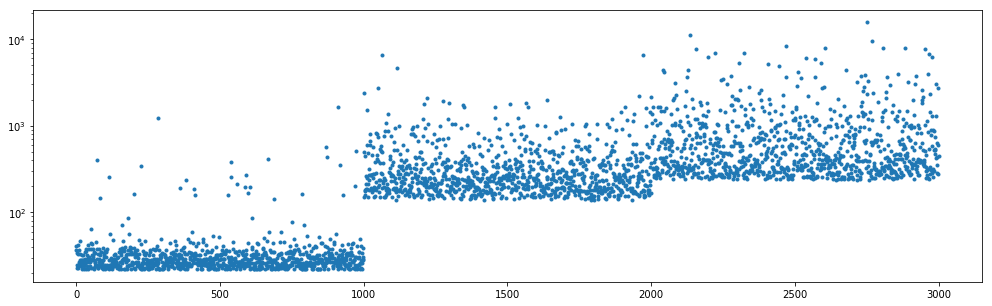

In [57]:
train.data_info(True)
wc = train.remove_short_documents(nwords=20, vocab='full')
train.data_info()
plt.figure(figsize=(17,5))
plt.semilogy(wc, '.');

In [58]:
train.embed()
train.data_info()

23596 words not found in corpus
N = 3000 documents, M = 15136 words, sparsity=1.3432%


most frequent words
    0: people      14623 counts
    1: egypt       14230 counts
    2: government  12132 counts
    3: mubarak      8859 counts
    4: new          7758 counts
    5: egyptian     6922 counts
    6: world        6259 counts
    7: time         5880 counts
    8: president    5824 counts
    9: country      5715 counts
   10: military     5226 counts
   11: political    4965 counts
   12: state        4662 counts
   13: israel       4495 counts
   14: power        4110 counts
   15: police       4088 counts
   16: protesters   4087 counts
   17: american     3973 counts
   18: years        3846 counts
   19: day          3769 counts
N = 3000 documents, M = 1000 words, sparsity=10.9637%


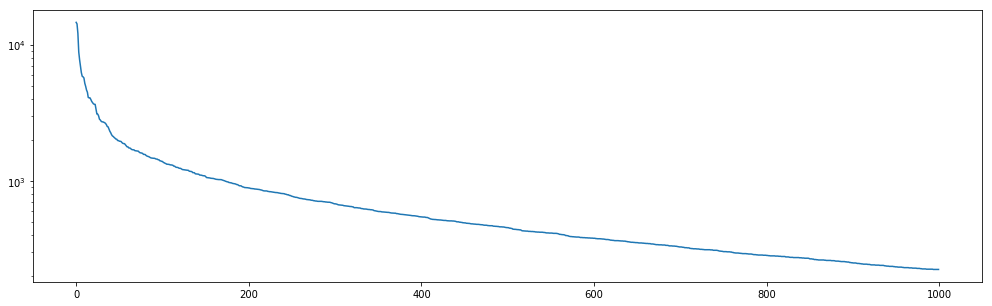

In [59]:
freq = train.keep_top_words(1000, 20)
train.data_info()
plt.figure(figsize=(17,5))
plt.semilogy(freq);

In [60]:
wc = train.remove_short_documents(nwords=5, vocab='selected')
train.data_info(True)

N = 3000 documents, M = 1000 words, sparsity=10.9637%
   1000 documents in class  0 (social_media)
   1000 documents in class  1 (news)
   1000 documents in class  2 (weblog)


#### Data normalization

In [61]:
train.normalize(norm='l1')

### 4.3 Test data <a class="anchor" id="43"></a>

Similarly as for the train data, we *prepare* test data. Firstly, we load the data (from the file we previously saved data in) and do preprocessing.

Furthermore, we keep only the words which appear in the training set as well.

Finally, we do data normalization, using $l_1$ norm.

In [62]:
test = utils.Posts(data_home=data_directory, subset='test')
test.clean_text(num='substitute')
test.vectorize(vocabulary=train.vocab)
test.data_info()
wc = test.remove_short_documents(nwords=5, vocab='selected')
test.data_info(True)
test.normalize(norm='l1')

N = 1500 documents, C = 3 classes
N = 1500 documents, M = 1000 words, sparsity=11.0142%
N = 1500 documents, M = 1000 words, sparsity=11.0142%
    500 documents in class  0 (social_media)
    500 documents in class  1 (news)
    500 documents in class  2 (weblog)


### 4.4 Words graph <a class="anchor" id="44"></a>

Once we have prepared training and testing data we also need to create the entry graph for our models. Firstly, we do embeddings of all our training words and denote that as *graph_data*. From this data, we calculate cosine distance between each pair of words. We keep only the strongliest connected words as neighbours in the graph, while other edges are deleted. From such distances, we create adjacency matrix. Furthermore, we create a Laplacian matrix, which we will use a a part of model.

In [63]:
graph_data = train.embeddings.astype(np.float32)

In [64]:
dist, idx = graph.distance_sklearn_metrics(graph_data, k=min_number_edges, metric=similarity_measure)
A = graph.adjacency(dist, idx)
print("{} > {} edges".format(A.nnz//2, min_number_edges*graph_data.shape[0]//2))
A = graph.replace_random_edges(A, 0)
graphs, perm = coarsening.coarsen(A, levels=coarsening_levels, self_connections=False)
L = [graph.laplacian(A, normalized=True) for A in graphs]

10855 > 8000 edges
Layer 0: M_0 = |V| = 1000 nodes (0 added),|E| = 10855 edges


In [65]:
train_data = train.data.astype(np.float32)
test_data = test.data.astype(np.float32)
train_labels = train.labels
test_labels = test.labels

train_data = scipy.sparse.csr_matrix(coarsening.perm_data(train_data.toarray(), perm))
test_data = scipy.sparse.csr_matrix(coarsening.perm_data(test_data.toarray(), perm))

### 4.5 Validation data <a class="anchor" id="45"></a>

In [66]:
val_data = test_data
val_labels = test_labels

### 4.6 Classification <a class="anchor" id="46"></a>

In this section we want to train different models in order to experiment how they work on our data and and to compare the results.
Firstly, we set the parameters which will be common for most of the models, such as e.g. non-linear *ReLU* function. Furhtermore, we train 7 different neural network models for our input and output.

**_Model 1:_**: Network is composed of input, zero hidden layers and one output layer with softmax function. 

**_Model 2:_**: Network is composed of input, one hidden layer and one output layer with softmax function. 

**_Model 3:_**: Network is composed of input, two hidden layers and one output layer with softmax function. 

**_Model 4:_**: Network is composed of input, one convolutional layer with *fourier* filter and one output layer with softmax function. 

**_Model 5:_**: Network is composed of input, one convolutional layer with *spline* filter  and one output layer with softmax function. 

**_Model 6:_**: Network is composed of input, one convolutional layer with *chebyshev polynomial* filter  and one output layer with softmax function. 

**_Model 7:_**: Network is composed of input, one convolutional layer with *chebyshev polynomial* filter, one hidden layer  and one output layer with softmax function. 

In [68]:
common = {}
common['num_epochs']     = 80
common['batch_size']     = 100
common['decay_steps']    = len(train_labels) / common['batch_size']
common['eval_frequency'] = 5 * common['num_epochs']
common['filter']         = 'chebyshev5'
common['brelu']          = 'b1relu'
common['pool']           = 'mpool1'
C = max(train_labels) + 1  # number of classes

model_perf = utils.model_perf()

In [69]:
name = 'softmax'
params = common.copy()
params['regularization'] = 0
params['dropout']        = 1
params['learning_rate']  = 1e3
params['decay_rate']     = 0.95
params['momentum']       = 0.9
params['F']              = []
params['K']              = []
params['p']              = []
params['M']              = [C]
model_perf.test(models.cgcnn(L, **params), name, params,
                train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 1000
  layer 1: logits (softmax)
    representation: M_1 = 3
    weights: M_0 * M_1 = 1000 * 3 = 3000
    biases: M_1 = 3
step 400 / 2400 (epoch 13.33 / 80):
  learning_rate = 5.13e+02, loss_average = 8.73e+01
  validation accuracy: 55.80 (837 / 1500), f1 (weighted): 46.19, loss: 6.08e+01
  time: 2s (wall 1s)
step 800 / 2400 (epoch 26.67 / 80):
  learning_rate = 2.64e+02, loss_average = 1.83e+01
  validation accuracy: 67.27 (1009 / 1500), f1 (weighted): 66.99, loss: 2.00e+01
  time: 4s (wall 2s)
step 1200 / 2400 (epoch 40.00 / 80):
  learning_rate = 1.35e+02, loss_average = 1.09e+01
  validation accuracy: 66.93 (1004 / 1500), f1 (weighted): 66.76, loss: 1.73e+01
  time: 5s (wall 2s)
step 1600 / 2400 (epoch 53.33 / 80):
  learning_rate = 6.60e+01, loss_average = 7.29e+00
  validation accuracy: 66.13 (992 / 1500), f1 (weighted): 65.77, loss: 1.58e+01
  time: 7s (wall 3s)
step 2000 / 2400 (epoch 66.67 / 80):
  learning_rate = 3.39e+01, loss_average = 6.83e+0

In [70]:
name = 'fc_softmax'
params = common.copy()
params['regularization'] = 0
params['dropout']        = 1
params['learning_rate']  = 0.1
params['decay_rate']     = 0.95
params['momentum']       = 0.9
params['F']              = []
params['K']              = []
params['p']              = []
params['M']              = [2500, C]
model_perf.test(models.cgcnn(L, **params), name, params,
                train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 1000
  layer 1: fc1
    representation: M_1 = 2500
    weights: M_0 * M_1 = 1000 * 2500 = 2500000
    biases: M_1 = 2500
  layer 2: logits (softmax)
    representation: M_2 = 3
    weights: M_1 * M_2 = 2500 * 3 = 7500
    biases: M_2 = 3
step 400 / 2400 (epoch 13.33 / 80):
  learning_rate = 5.13e-02, loss_average = 7.14e-01
  validation accuracy: 58.80 (882 / 1500), f1 (weighted): 47.44, loss: 7.97e-01
  time: 82s (wall 12s)
step 800 / 2400 (epoch 26.67 / 80):
  learning_rate = 2.64e-02, loss_average = 6.26e-01
  validation accuracy: 69.20 (1038 / 1500), f1 (weighted): 66.56, loss: 6.61e-01
  time: 163s (wall 25s)
step 1200 / 2400 (epoch 40.00 / 80):
  learning_rate = 1.35e-02, loss_average = 5.93e-01
  validation accuracy: 65.53 (983 / 1500), f1 (weighted): 62.39, loss: 6.42e-01
  time: 245s (wall 37s)
step 1600 / 2400 (epoch 53.33 / 80):
  learning_rate = 6.60e-03, loss_average = 5.80e-01
  validation accuracy: 71.60 (1074 / 1500), f1 (weighted): 71.17,

In [71]:
name = 'fc_fc_softmax'
params = common.copy()
params['regularization'] = 0
params['dropout']        = 1
params['learning_rate']  = 0.1
params['decay_rate']     = 0.95
params['momentum']       = 0.9
params['F']              = []
params['K']              = []
params['p']              = []
params['M']              = [2500, 500, C]
model_perf.test(models.cgcnn(L, **params), name, params,
                train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 1000
  layer 1: fc1
    representation: M_1 = 2500
    weights: M_0 * M_1 = 1000 * 2500 = 2500000
    biases: M_1 = 2500
  layer 2: fc2
    representation: M_2 = 500
    weights: M_1 * M_2 = 2500 * 500 = 1250000
    biases: M_2 = 500
  layer 3: logits (softmax)
    representation: M_3 = 3
    weights: M_2 * M_3 = 500 * 3 = 1500
    biases: M_3 = 3
step 400 / 2400 (epoch 13.33 / 80):
  learning_rate = 5.13e-02, loss_average = 5.82e-01
  validation accuracy: 68.93 (1034 / 1500), f1 (weighted): 66.13, loss: 5.59e-01
  time: 120s (wall 18s)
step 800 / 2400 (epoch 26.67 / 80):
  learning_rate = 2.64e-02, loss_average = 4.63e-01
  validation accuracy: 77.13 (1157 / 1500), f1 (weighted): 77.03, loss: 4.81e-01
  time: 241s (wall 36s)
step 1200 / 2400 (epoch 40.00 / 80):
  learning_rate = 1.35e-02, loss_average = 4.22e-01
  validation accuracy: 79.27 (1189 / 1500), f1 (weighted): 79.40, loss: 4.47e-01
  time: 363s (wall 54s)
step 1600 / 2400 (epoch 53.33 / 80):
  

In [72]:
name = 'fgconv_softmax'
params = common.copy()
params['filter']         = 'fourier'
params['regularization'] = 0
params['dropout']        = 1
params['learning_rate']  = 0.001
params['decay_rate']     = 1
params['momentum']       = 0
params['F']              = [32]
params['K']              = [L[0].shape[0]]
params['p']              = [1]
params['M']              = [C]
model_perf.test(models.cgcnn(L, **params), name, params,
                train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 1000
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 1000 * 32 / 1 = 32000
    weights: F_0 * F_1 * K_1 = 1 * 32 * 1000 = 32000
    biases: F_1 = 32
  layer 2: logits (softmax)
    representation: M_2 = 3
    weights: M_1 * M_2 = 32000 * 3 = 96000
    biases: M_2 = 3
step 400 / 2400 (epoch 13.33 / 80):
  learning_rate = 1.00e-03, loss_average = 1.10e+00


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 33.33 (500 / 1500), f1 (weighted): 16.67, loss: 1.10e+00
  time: 892s (wall 122s)
step 800 / 2400 (epoch 26.67 / 80):
  learning_rate = 1.00e-03, loss_average = 1.10e+00
  validation accuracy: 34.00 (510 / 1500), f1 (weighted): 18.07, loss: 1.10e+00
  time: 1793s (wall 242s)
step 1200 / 2400 (epoch 40.00 / 80):
  learning_rate = 1.00e-03, loss_average = 1.10e+00
  validation accuracy: 34.07 (511 / 1500), f1 (weighted): 18.19, loss: 1.10e+00
  time: 2691s (wall 364s)
step 1600 / 2400 (epoch 53.33 / 80):
  learning_rate = 1.00e-03, loss_average = 1.10e+00
  validation accuracy: 34.13 (512 / 1500), f1 (weighted): 18.33, loss: 1.10e+00
  time: 3587s (wall 486s)
step 2000 / 2400 (epoch 66.67 / 80):
  learning_rate = 1.00e-03, loss_average = 1.10e+00
  validation accuracy: 33.33 (500 / 1500), f1 (weighted): 16.67, loss: 1.10e+00
  time: 4486s (wall 612s)
step 2400 / 2400 (epoch 80.00 / 80):
  learning_rate = 1.00e-03, loss_average = 1.10e+00
  validation accuracy: 36.4

In [73]:
name = 'sgconv_softmax'
params = common.copy()
params['filter']         = 'spline'
params['regularization'] = 1e-3
params['dropout']        = 1
params['learning_rate']  = 0.1
params['decay_rate']     = 0.999
params['momentum']       = 0
params['F']              = [32]
params['K']              = [5]
params['p']              = [1]
params['M']              = [C]
model_perf.test(models.cgcnn(L, **params), name, params,
                train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 1000
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 1000 * 32 / 1 = 32000
    weights: F_0 * F_1 * K_1 = 1 * 32 * 5 = 160
    biases: F_1 = 32
  layer 2: logits (softmax)
    representation: M_2 = 3
    weights: M_1 * M_2 = 32000 * 3 = 96000
    biases: M_2 = 3
step 400 / 2400 (epoch 13.33 / 80):
  learning_rate = 9.87e-02, loss_average = 1.44e+00


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 33.33 (500 / 1500), f1 (weighted): 16.67, loss: 1.44e+00
  time: 895s (wall 122s)
step 800 / 2400 (epoch 26.67 / 80):
  learning_rate = 9.74e-02, loss_average = 1.42e+00
  validation accuracy: 33.33 (500 / 1500), f1 (weighted): 16.67, loss: 1.42e+00
  time: 1797s (wall 243s)
step 1200 / 2400 (epoch 40.00 / 80):
  learning_rate = 9.62e-02, loss_average = 1.39e+00
  validation accuracy: 33.33 (500 / 1500), f1 (weighted): 16.67, loss: 1.39e+00
  time: 2691s (wall 365s)
step 1600 / 2400 (epoch 53.33 / 80):
  learning_rate = 9.48e-02, loss_average = 1.37e+00
  validation accuracy: 33.33 (500 / 1500), f1 (weighted): 16.67, loss: 1.37e+00
  time: 3591s (wall 485s)
step 2000 / 2400 (epoch 66.67 / 80):
  learning_rate = 9.36e-02, loss_average = 1.35e+00
  validation accuracy: 33.33 (500 / 1500), f1 (weighted): 16.67, loss: 1.35e+00
  time: 4492s (wall 605s)
step 2400 / 2400 (epoch 80.00 / 80):
  learning_rate = 9.24e-02, loss_average = 1.33e+00
  validation accuracy: 33.3

In [74]:
name = 'cgconv_softmax'
params = common.copy()
params['regularization'] = 1e-3
params['dropout']        = 1
params['learning_rate']  = 0.1
params['decay_rate']     = 0.999
params['momentum']       = 0
params['F']              = [32]
params['K']              = [5]
params['p']              = [1]
params['M']              = [C]
model_perf.test(models.cgcnn(L, **params), name, params,
                train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 1000
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 1000 * 32 / 1 = 32000
    weights: F_0 * F_1 * K_1 = 1 * 32 * 5 = 160
    biases: F_1 = 32
  layer 2: logits (softmax)
    representation: M_2 = 3
    weights: M_1 * M_2 = 32000 * 3 = 96000
    biases: M_2 = 3
step 400 / 2400 (epoch 13.33 / 80):
  learning_rate = 9.87e-02, loss_average = 1.43e+00
  validation accuracy: 55.00 (825 / 1500), f1 (weighted): 45.81, loss: 1.43e+00
  time: 87s (wall 18s)
step 800 / 2400 (epoch 26.67 / 80):
  learning_rate = 9.74e-02, loss_average = 1.32e+00
  validation accuracy: 57.93 (869 / 1500), f1 (weighted): 48.73, loss: 1.31e+00
  time: 174s (wall 35s)
step 1200 / 2400 (epoch 40.00 / 80):
  learning_rate = 9.62e-02, loss_average = 1.12e+00
  validation accuracy: 66.80 (1002 / 1500), f1 (weighted): 64.82, loss: 1.11e+00
  time: 263s (wall 53s)
step 1600 / 2400 (epoch 53.33 / 80):
  learning_rate = 9.48e-02, loss_average = 1.01e+00
  validation accuracy: 68.60 (1

In [75]:
name = 'cgconv_fc_softmax'
params = common.copy()
params['regularization'] = 0
params['dropout']        = 1
params['learning_rate']  = 0.1
params['decay_rate']     = 0.999
params['momentum']       = 0
params['F']              = [5]
params['K']              = [15]
params['p']              = [1]
params['M']              = [100, C]
model_perf.test(models.cgcnn(L, **params), name, params,
                train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 1000
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 1000 * 5 / 1 = 5000
    weights: F_0 * F_1 * K_1 = 1 * 5 * 15 = 75
    biases: F_1 = 5
  layer 2: fc1
    representation: M_2 = 100
    weights: M_1 * M_2 = 5000 * 100 = 500000
    biases: M_2 = 100
  layer 3: logits (softmax)
    representation: M_3 = 3
    weights: M_2 * M_3 = 100 * 3 = 300
    biases: M_3 = 3
step 400 / 2400 (epoch 13.33 / 80):
  learning_rate = 9.87e-02, loss_average = 1.10e+00


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 33.40 (501 / 1500), f1 (weighted): 16.81, loss: 1.10e+00
  time: 115s (wall 26s)
step 800 / 2400 (epoch 26.67 / 80):
  learning_rate = 9.74e-02, loss_average = 9.71e-01
  validation accuracy: 58.00 (870 / 1500), f1 (weighted): 47.89, loss: 9.62e-01
  time: 229s (wall 50s)
step 1200 / 2400 (epoch 40.00 / 80):
  learning_rate = 9.62e-02, loss_average = 6.25e-01
  validation accuracy: 68.80 (1032 / 1500), f1 (weighted): 68.75, loss: 6.01e-01
  time: 342s (wall 74s)
step 1600 / 2400 (epoch 53.33 / 80):
  learning_rate = 9.48e-02, loss_average = 5.59e-01
  validation accuracy: 71.40 (1071 / 1500), f1 (weighted): 71.26, loss: 5.50e-01
  time: 457s (wall 98s)
step 2000 / 2400 (epoch 66.67 / 80):
  learning_rate = 9.36e-02, loss_average = 1.06e+00
  validation accuracy: 45.13 (677 / 1500), f1 (weighted): 35.80, loss: 1.03e+00
  time: 574s (wall 123s)
step 2400 / 2400 (epoch 80.00 / 80):
  learning_rate = 9.24e-02, loss_average = 5.20e-01
  validation accuracy: 70.80 (106

Finally, we observe that test accuracy vary a lot for different models. The best model for our data, is neural network with two hidden layers, with accuracy around 80 %. We can say that this is a good accuracy, because words which appear in the post don't neccessarely uniquely represent the media they appear on. I.e. some words can appear equally on different types of media and therefore they are not particualary helpful in this classifiction. On the other hand, it is noticable that usually different types of vocabularies and expression, appear in the *news article* and in a *social media post*.  

What can be observed here, is that the model with convolutional layer is not our best model. This comes a bit as a surprise, since we expected that such model should exceed the others. On the other hand, models with *chebyshev polynomial* filter still give very good results (around 70% accuracy on the test dataset). Furthermore, if we look at the training and test accuracies, they are very close for models with *chebyshev polynomial* filter. This means that while other models are maximizing their accuracy, models with convolutional layer are underfitting. One way to resolve this problem would be to optimize all hyperparameters and fit the model better to the data. However, the goal of this part of our project was to just experiment with convolutional neural networks and draw some conclusions, and not to make a perfect model for this precise data.

  accuracy        F1             loss        time [ms]  name
test  train   test  train   test     train
70.80 69.63   68.31 67.03   5.38e-01 5.33e-01    61   cgconv_fc_softmax
69.47 69.43   69.20 69.25   8.79e-01 8.86e-01    44   cgconv_softmax
80.47 86.40   80.55 86.40   4.20e-01 3.43e-01    45   fc_fc_softmax
71.33 76.47   71.54 76.45   6.18e-01 5.69e-01    31   fc_softmax
36.40 36.33   22.68 22.60   1.10e+00 1.10e+00   309   fgconv_softmax
33.33 33.33   16.67 16.67   1.33e+00 1.33e+00   304   sgconv_softmax
67.53 80.53   67.64 80.52   1.50e+01 5.78e+00     2   softmax


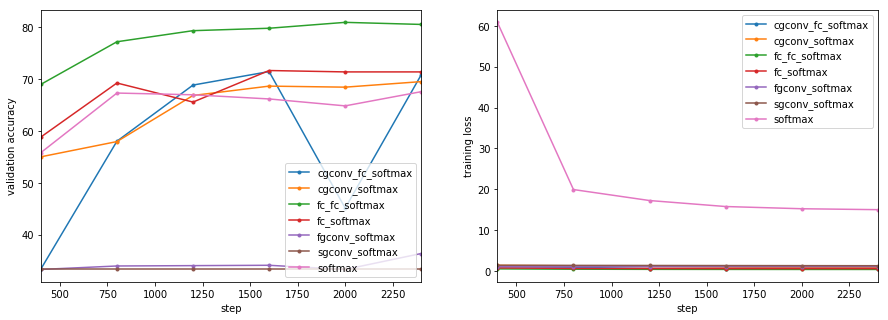

In [76]:
model_perf.show()

## 5. Constructing social graph with named-entities <a class="anchor" id="5"></a>

In [1]:
# Import
import numpy as np
import string
import pickle
import requests
from bs4 import BeautifulSoup
import urllib
import codecs
from collections import Counter
from nltk.stem.porter import *
from nltk import wordnet as wn
import networkx as nx
import matplotlib.pyplot as plt

In this section, we are going to construct a social graph with named-entities. <br>
We start by loading the News Dataset.


In [2]:
def extract_detokenized(df):
    """
    Separates bigrams
    param df: dataframe (with feature Tokens)
    returns: array of arrays of Tokens
    """
    return [' '.join([token.replace('_',' ') for token in tokens]).split() for tokens in list(df.Tokens)]

# Load News data
data = extract_detokenized(pickle.load(open('./data/MAINSTREAM_NEWS_en.pkl', 'rb')).reset_index(drop=True).reset_index(drop=True))

### 5.1. English Dictionary <a class="anchor" id="51"></a>

An initial dictionary is created as follows: <br>
First, a list of the 40’000 most common words with their respective occurence frequency in the english language is scraped from wiktionary.org. This dictionary is further extended by adding a comprehensive set of acronyms and smileys from netlingo.com. <br>
The file scraping.py performs the scraping task, and english_dictionary.py groups all scraped lists in a single dictionary.

In [3]:
#Load english dictionary
english_dictionary = set(pickle.load(open('dictionaries.p', 'rb'))[0].keys())

### 5.2. Filter tokens <a class="anchor" id="52"></a>

In order to recognize Named-entities, each word is filtered by checking if it: 
1. doesn't belong to the initial dictionary
2. isn't a common word using Wordnet Synsets.
3. doesn't contain digits.
4. is the same as its word stem.
5. has more than 3 charcters.

Otherwise, the word will be ignored.

In [4]:
stemmer = PorterStemmer()

def hasDigits(word):
    """
    Checks if a word contain a digit
    param word: String
    return: True if word contains digit
    """
    return any(char.isdigit() for char in word)

def Filter(word):
    return len(wn.wordnet.synsets(word))==0 and not hasDigits(word) and stemmer.stem(word)==word and len(word)>3

In [5]:
all_words = set([word for tokens in data for word in tokens])
filtered_names = set([word for word in all_words-english_dictionary if Filter(word)])

### 5.3. Social Graph Construction <a class="anchor" id="53"></a>

For each document, we perform the Named Entity extraction. <br>
For some cases, in general, when the document belongs to another language, the size of the extracted list is very high, since most of word are not recognizable as english word. So, a threshold is fixed in order to solve this issue. <br>
Each list of names corresponding to a document will define a new path in the graph.

In [6]:
# Store all paths in connections
connections = []

for document in np.unique(data):
    if len(document) > 0:
        names = [word for word in document if word in filtered_names]
        ratio  = round(len(names)/len(document)*100, 2)
        if len(names) > 1 and ratio < 3 and ratio > 0: connections.append(names)

In [7]:
def connect_nodes(G, connection):
    """
    Add path 'connection' to the graph G
    param G: graph
    param connection: array of nodes
    returns graph
    """
    for node1, node2 in zip(connection[:-1], connection[1:]):
        if node1 != node2:
            if G.has_edge(node1, node2):
                # we added this one before, just increase the weight by one
                G[node1][node2]['weight'] += 1
            else:
                # new edge. add with weight=1
                G.add_edge(node1, node2, weight=1)
    return G

In [8]:
# initialize the Graph
G = nx.Graph()
# add edges
for connection in connections:
    G = connect_nodes(G, connection)

len(G.nodes), len(G.edges)

(8931, 16730)

The resulting graph contains **8931** nodes, and **16730** edges.

### 5.4. Degree Distribution  <a class="anchor" id="54"></a>

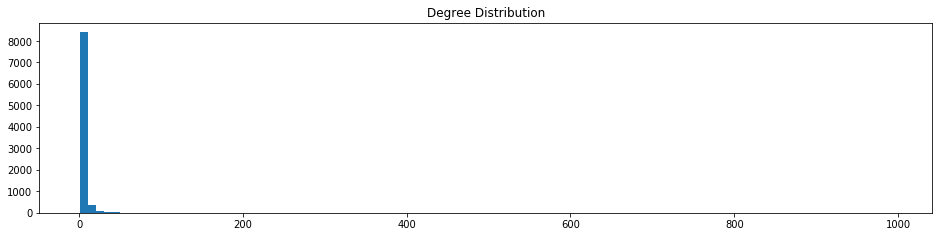

The minimum degree is 1 and the maximum is 992


In [9]:
degree_sequence = sorted(dict(nx.degree(G)).values(),reverse=True)
plt.figure(figsize=(16,3.5))
plt.hist(degree_sequence, bins=100);
plt.title('Degree Distribution')
plt.show()
print('The minimum degree is {} and the maximum is {}'.format(min(degree_sequence), max(degree_sequence)))

From the degree distribution, we can see that the majority of nodes (more than 8000) has degree less than 10. <br>
The minimum degree is 1 and the maximum is 992.

### 5.5. Connected Components <a class="anchor" id="55"></a>

In [10]:
# Connected Components
graphs = list(nx.connected_component_subgraphs(G))
giant_G = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)[0]
small_G = sorted(nx.connected_component_subgraphs(G), key=len)[0]
print('The graph contains {} connected components, the largest one (Giant component) contains {} nodes and the smallest one contains only {} nodes.'.format(len(graphs), len(giant_G), len(small_G)))

The graph contains 160 connected components, the largest one (Giant component) contains 8554 nodes and the smallest one contains only 2 nodes.


The graph contains 160 connected components. The giant component contains 8554 nodes (95.8 %) <br>
Let's have a look to the components size distribution.

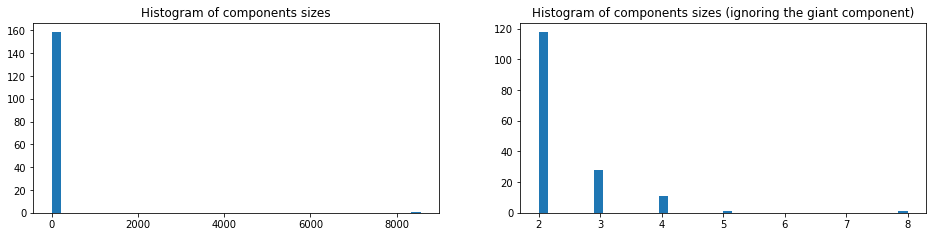

In [11]:
plt.figure(figsize=(16,3.5))

plt.subplot(121)
components_sizes = [len(g) for g in graphs]
plt.hist(components_sizes, bins=40);
plt.title('Histogram of components sizes')

plt.subplot(122)
components_sizes = [len(g) for g in graphs[1:]]
plt.hist(components_sizes, bins=40);
plt.title('Histogram of components sizes (ignoring the giant component)')
plt.show()

From both Histograms above, we can conclude that in addition to the giant component containing (≈ 95.8% of nodes), we have 159 components with a very low number of nodes (less than 8). The majority (≈ 118) contains only 2 nodes. <br>
We considered this 159 tinies components as noise, and we decided to ignore them.

### 5.6. Graph Centrality <a class="anchor" id="56"></a>

We use the Graph centrality (degree centrality) in order to identify the most important and influent names in the Social graph.

In [12]:
centrality = nx.degree_centrality(G)
centrality_ = []
for k, v in centrality.items():
    centrality_.append((v,k))
centrality_.sort(reverse=True)

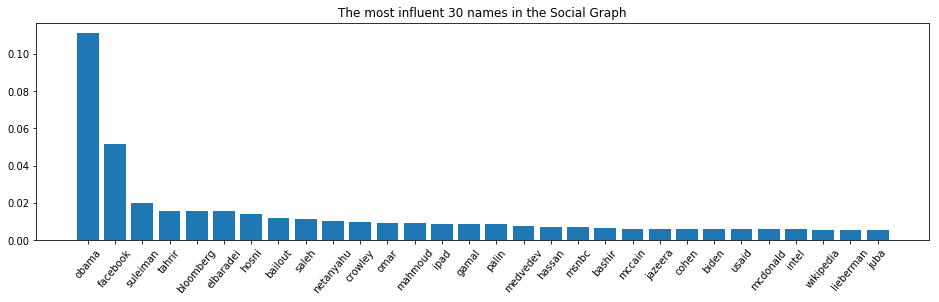

In [13]:
best_nodes = [m for n,m in centrality_[:30]]
best_scores = [n for n,m in centrality_[:30]]

plt.figure(figsize=(16,4))
plt.bar(range(len(best_scores)), best_scores)
plt.xticks(range(len(best_nodes)), best_nodes, rotation=50)
plt.title('The most influent 30 names in the Social Graph')
plt.show()

From the graph and the plot above, showing the most influent 30 names in the Social graph, we categorize this names to 5 categories: <br>

| Persons          |   Places   |Social Media (website)|(News) Organizations| Others      |
|------            |------      |------                | ------             | -----       |
|   obama          | tahrir     |facebook              | bloomberg          | bailout     |
|   suleiman       | juba       |  Wikipedia           | jazeera            | ipad        |
|   elbaradei      |            |                      | usaid              | intel       |
|   hosni          |            |                   | msnbc              |             |
|   saleh          |            |                   |                    |             |
|   netanyahu      |            |                   |                    |             |
|   crowly         |            |                   |                    |             |
|   omar           |            |                   |                    |             |
|   mahmoud        |            |                   |                    |             |
|   gamal          |            |                   |                    |             |
|   palin          |            |                   |                    |             |
|   medvedev       |            |                   |                    |             |
|   hassan         |            |                   |                    |             |
|   bashir         |            |                   |                    |             |
|   mccain         |            |                   |                    |             |
|   cohen          |            |                   |                    |             |
|   biden          |            |                   |                    |             |
|   lieberman      |            |                   |                    |             |
|   mcdonald       |            |                   |                    |             |

** Most of names are referring to persons (politicians, activists, ...) influencing directly or indirectly the egyptian revolution. In the list we can find:** 
<br> <br> ** Egyptians **
- **hosni 'Mohamed Hosni Mubarek'** (the ousted president)
- **elbaradei 'Mohamed ElBaradei'** (Egyptian Diplomat was prominently featured in the press regarding relatively recent politics in Egypt)
- **suleiman , Mahmoud 'Omar Mahmoud Suleiman'** ( Egyptian army general, politician, diplomat, and intelligence officer, he announced Mubarak's resignation and ceased being Vice President; governing power was transferred to the Armed Forces Supreme Council, of which Suleiman was not a member.
- **gamal 'Gamal Al Din Mohammed Hosni Ei Sayed Mubarak'** (the younger of the two sons of former Egyptian President Hosni Mubarak)

<br> ** Foreigners **
- **obama 'Barack Obama'** (44th President of the United States from 2009 to 2017)
- **maccain, cohen, biden, mcdonald ** ( American politicianns)
- **netanyahu 'Benjamin Netanyahu'** (Israeli politician serving as the 9th and current Prime Minister of Israel since 2009)
- **lieberman 'Avigdor Lieberman'** (Israeli politician who served in 2011 as Minister of Foreign affairs.)
- **medvedev 'Dmitry Medvedev'** (Russian politician,  from 2008 to 2012, Medvedev served as the third President of Russia)
- **saleh 'Ali Abdullah Saleh'** (the inaugural president of Yemen. In 2011, in wake of the "Arab Spring" that spread across Yemen, Saleh's time in office became more and more untenable, until eventually he was ousted as president of Yemen in 2012.)
- **bashir 'Omar Hassan Ahmad al-Bashir'** (Sudanese politician, the seventh president of Sudan)

<br> **Places**
- **tahrir 'Tahrir Square'** (Major public town square in Downtown Cairo, Egypt. The square has been the location and focus for political demonstrations in Cairo, most notably those that led to the 2011 Egyptian revolution and the resignation of President Hosni Mubarak.)
- **juba 'Juba'** (the capital and largest city of the Republic of South Sudan that gained its independence from the Republic of the Sudan in 2011.)

<br> **Social Media**
- **facebook 'Facebook'** (The social media where the egyptian revolution began)

<br> **(News) Organisations**
- **bloomerg, jazeera, msnbc 'Bloomberg, Al-Jazeera, MSNBC'** (The news organizations that covered exstensively the revolution).

### 5.7. Pruning the Graph <a class="anchor" id="57"></a>

**In order to see the inter-relationship between the most important nodes in the Social Graph, by keeping nodes with degree exceeding 50.**

In [14]:
H = G.copy()
degree_threshold = 50
del_nodes = [node for node in dict(G.degree).keys() if G.degree[node] < degree_threshold]
H.remove_nodes_from(del_nodes)
print('The resulting graph contains {} nodes.'.format(len(H.nodes)))

The resulting graph contains 28 nodes.


**Let's plot the subgraph of the most important nodes with degree exceeding 50.**

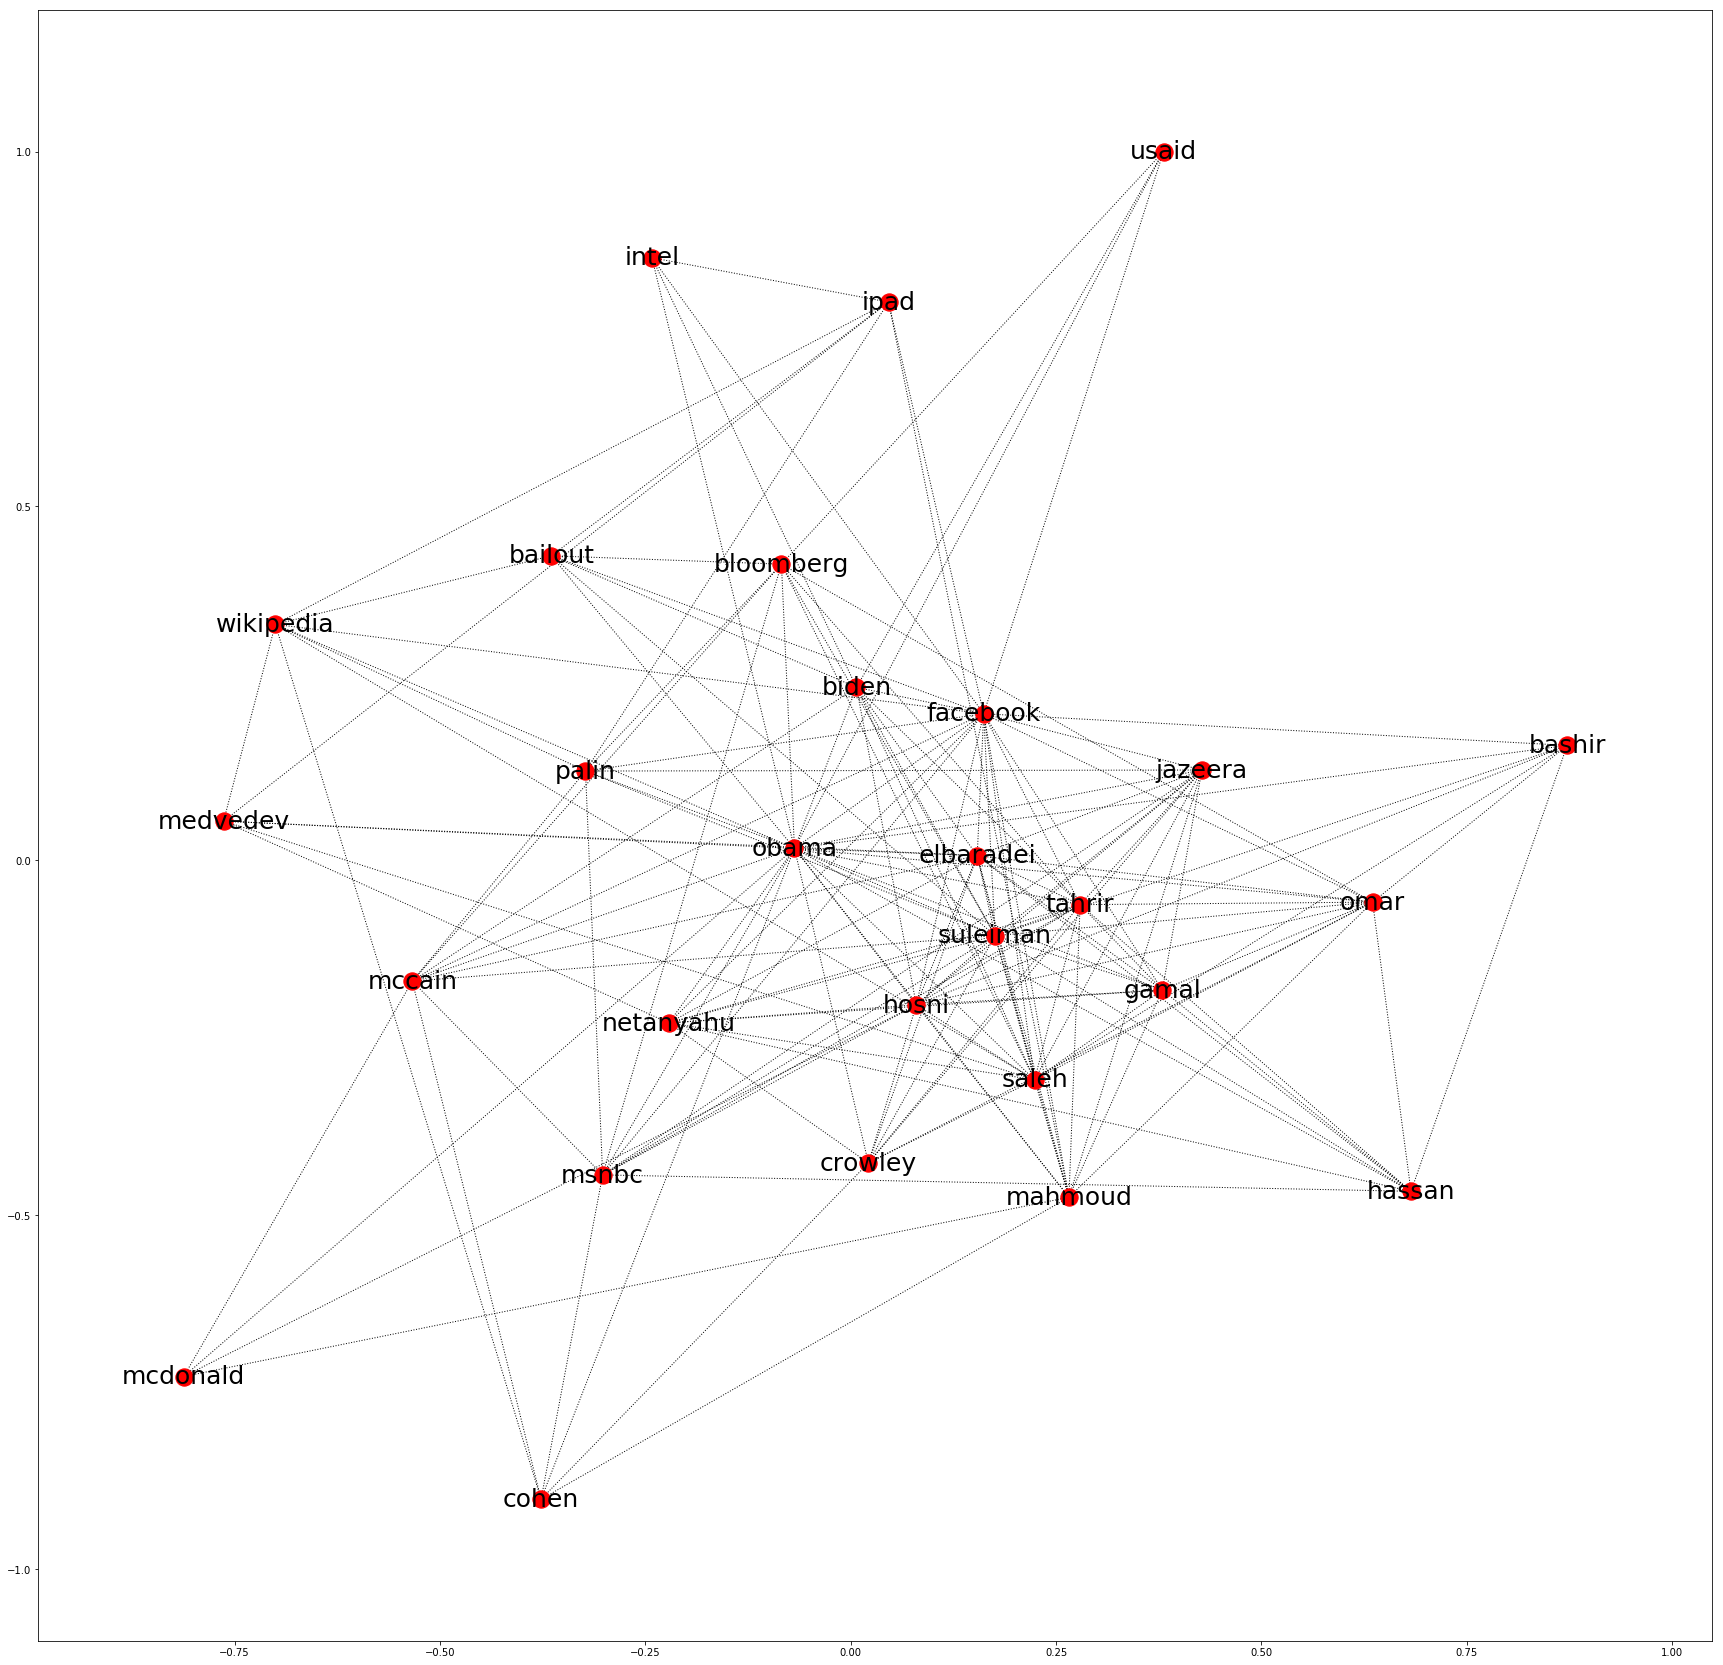

In [15]:
plt.figure(figsize=(30,30))
nx.draw_networkx(H, font_size=25, style='dotted')
plt.show()

**The subgraph shows the most influent names in the original graph, wich are approximately the same as before (clustering coefficient). Nodes are strongly connected.<br>
We can notice clearly that the most important nodes (in the center):**
- **tharir** the square from where the revolution began.
- **hosni, suleiman, elbaradei, gamal** the most important figures of the revolution.
- **obama** the most important foreign influencer.
- **jazeera** the qatari channel covered exstensively the revolution (24/7).
- **facebook** the most used social media during the revolution.

## 5.8. Ego Graph <a class="anchor" id="58"></a>

Another way to see the graph, is to focus on a given node, and spot its neighborhood. <br>
An interesting example is to take the 'tahrir' square as focal node, and have look to the corresponding ego-graph.

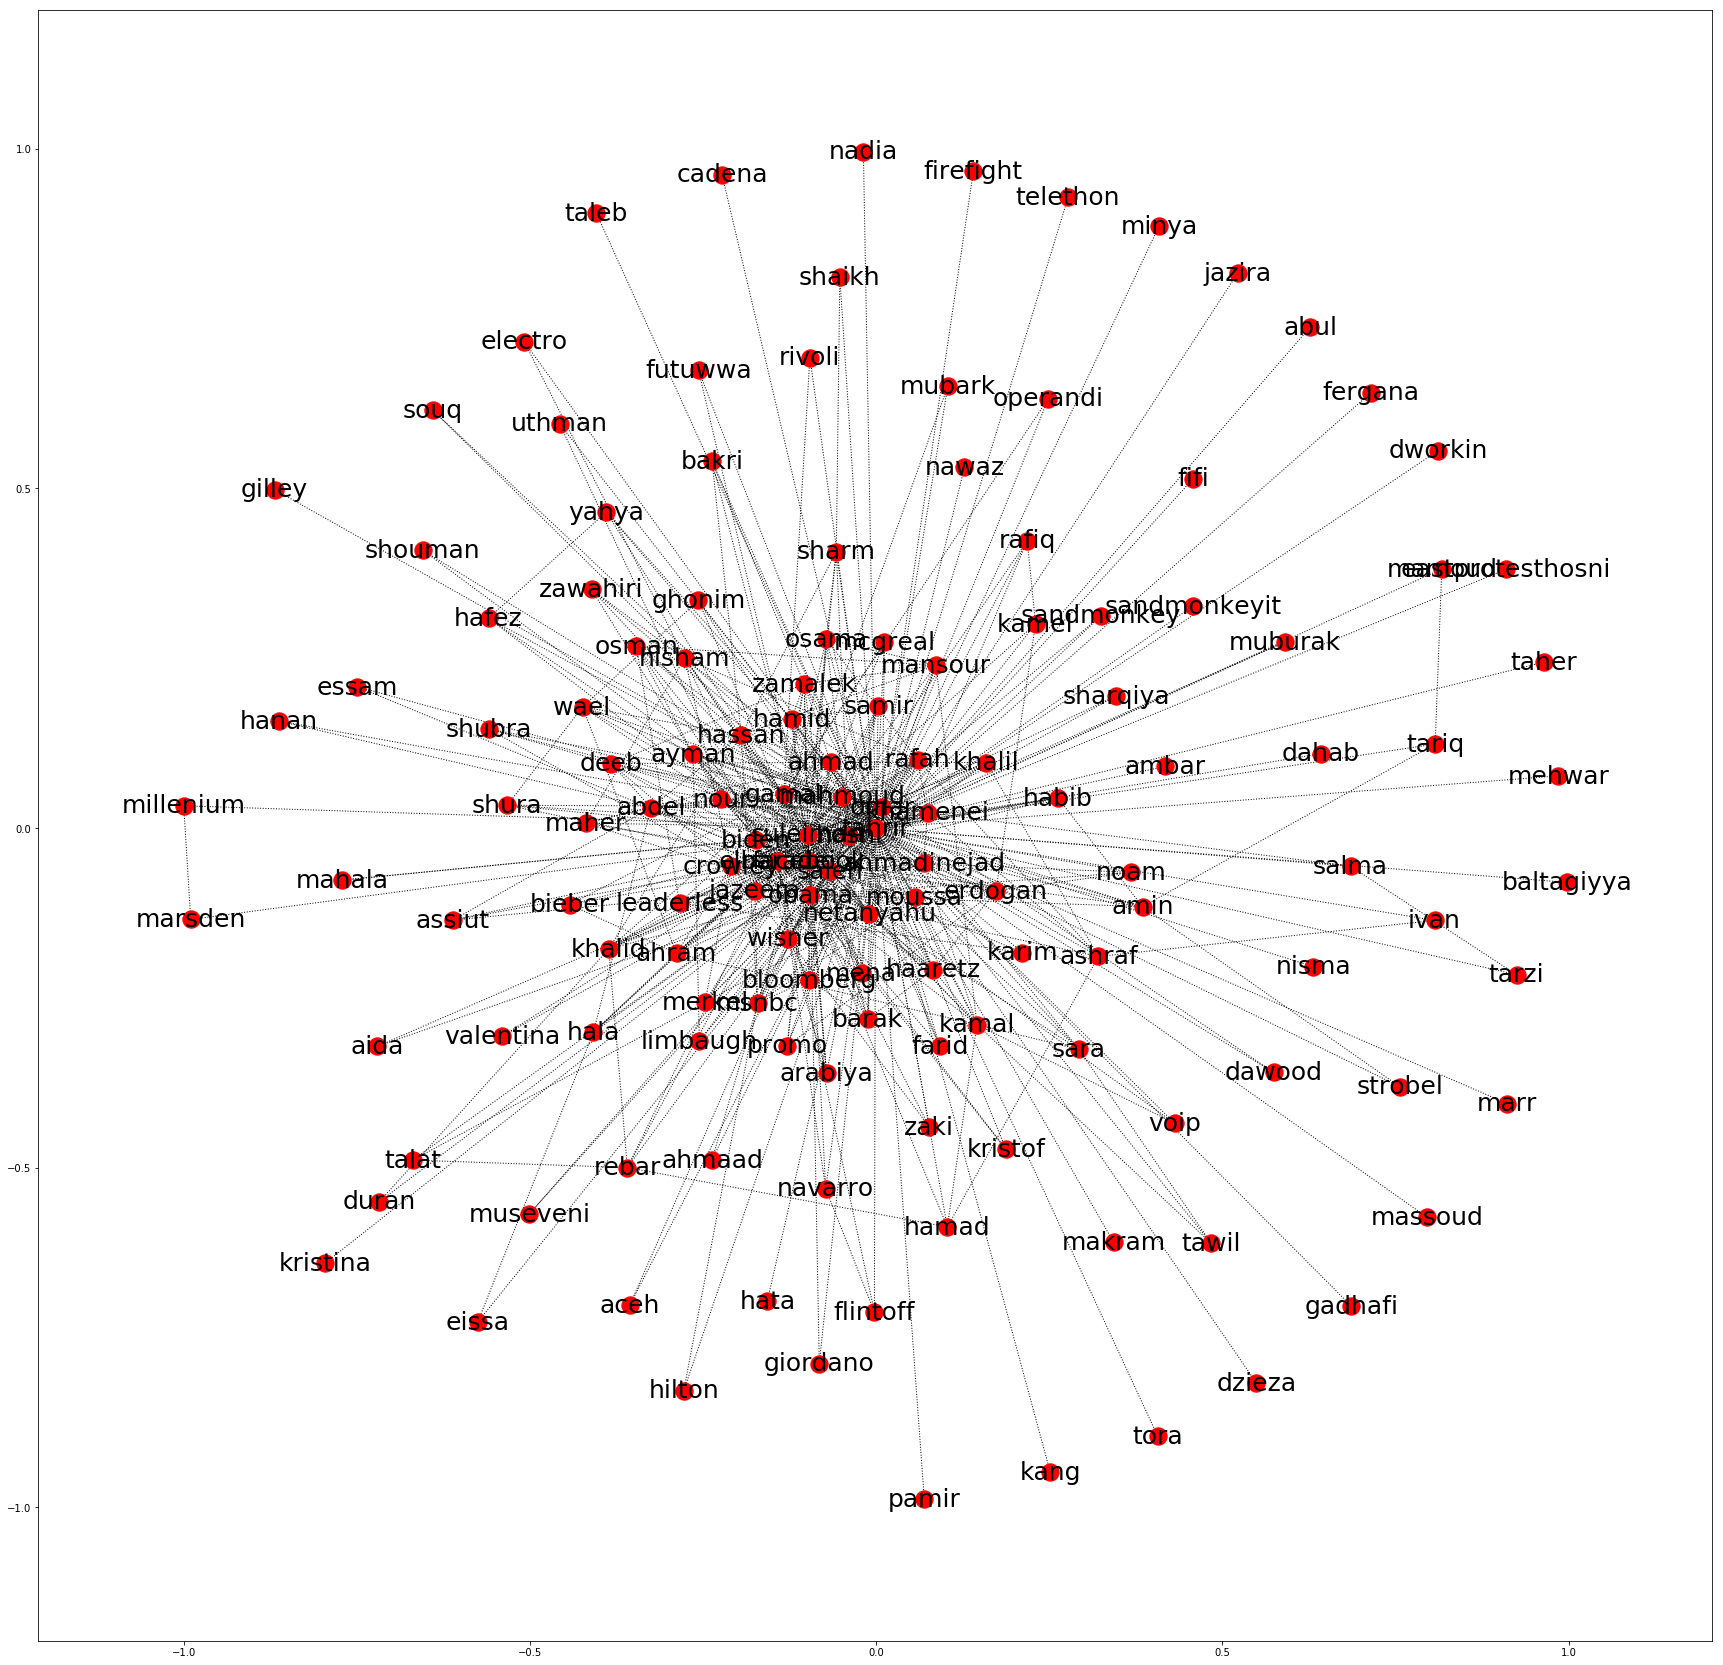

In [16]:
L = nx.ego_graph(G, 'tahrir', radius=1)
plt.figure(figsize=(30,30))
nx.draw_networkx(L, font_size=25, style='dotted')
plt.show()

This ego graph shows hundreds of names all around the famous Tahrir square. Most of them are arab first names, referring to the activists participating in the revolution (in place or on social media). <br>
With a bit of imagination, we can turn back the clock and make an make an analogy with the real Tahrir Square in the beginning of the January 25 Revolution, filled by thousands of protesters.

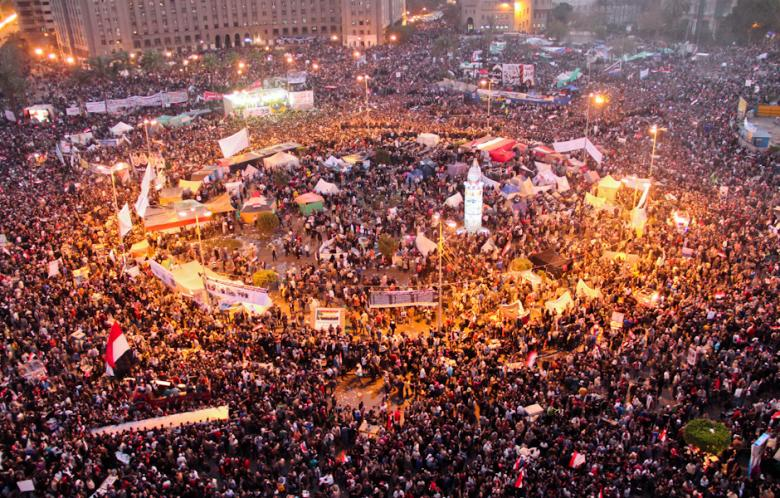

## Conclusion  <a class="anchor" id="6"></a>

In this project, we tackled the Tunisian and Egyptian Revolutions of 2011 with a Network Graph-oriented perspective.

First, we clustered posts in the second and third sections. We represented the posts using Word2Vec and computed their distances using cosine distances. Then we pruned a post's neighbours and got three clusters per country and per post type. We obtained clusters of posts that covered similar topics, and found that clustering was completed by the use of adjacency matrix and degree distribution.

In the fourth section, the goal was to experiment with implementation of an efficient generalization of the popular Convolutional Neural Networks (CNNs), using our data. Accuracies which we obtained for media prediction, just based on posts, are very good for different models. We observed that accuracy for models with convolutional layer could be improved by focusing on fitting this specific data better.

Finally, in the fifth section, the Social graph created using the Nemed-Entity Recognition on the News Dataset allows the extraction of the most influent persons during the Egyptian Revolution (such as presidents, politicians and activists), as well as the focal point of the revolution "Maydan At-Tahrir" or "Tahrir Square". More than that, we extracted some of the News organizations that covered extensively the event (Al-Jazeera in the foreground).